<a href="https://colab.research.google.com/github/smagara/AI-Exercises/blob/main/agent_langgraph_image_reader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Agent

In this notebook, **we're going to build a simple agent using using LangGraph**.

This notebook is part of the <a href="https://www.hf.co/learn/agents-course">Hugging Face Agents Course</a>, a free course from beginner to expert, where you learn to build Agents.

![Agents course share](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/communication/share.png)

As seen in the Unit 1, an agent needs 3 steps as introduced in the ReAct architecture :
[ReAct](https://react-lm.github.io/), a general agent architecture.
  
* `act` - let the model call specific tools
* `observe` - pass the tool output back to the model
* `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)


![Agent](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Agent.png)

In [1]:
%pip install -q -U langchain_openai langchain_core langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 418.7/418.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.1/606.1 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.5 MB/s eta 0:00:00


In [2]:
# prompt: make a function that takes a parameter SecretName such as "OPENAI_API_KEY" and sets it as an environment variable,
#  by first attempting to assign a Secret of that name from for example Colab, and if not found
#  prompts the user to paste it in and uses the user input to assign the env variable

# Example usage:
# HF_set_env_variable_from_secret("OPENAI_API_KEY")

import os
from google.colab import userdata  # Import Colab's secret storage module

def _get_secret_or_prompt(SecretName: str) -> str:
    """
    Retrieves a secret from Colab or prompts the user to enter it.

    Args:
        SecretName: The name of the secret to retrieve.

    Returns:
        The secret value.
    """
    # Try fetching from Colab's secret storage
    secret_value = userdata.get(SecretName)  # This accesses Colab Secrets
    if secret_value:
        return secret_value

    # Fallback to environment variable (if manually set)
    secret_value = os.getenv(SecretName)
    if secret_value:
        return secret_value

    # If not found, prompt user
    print(f"Secret '{SecretName}' not found. Please paste it in and press Enter:")
    secret_value = input().strip()
    return secret_value

def HF_set_env_variable_from_secret(SecretName: str):
    """
    Sets an environment variable using a secret retrieved from Colab or user input.

    Args:
        SecretName: The name of the secret to retrieve and assign as an environment variable.
    """
    secret_value = _get_secret_or_prompt(SecretName)
    os.environ[SecretName] = secret_value


In [3]:
import os

# Please setp your own key.
# os.environ["OPENAI_API_KEY"]="sk-xxxxxx"
HF_set_env_variable_from_secret("OPENAI_API_KEY")

In [4]:
import base64
from typing import List
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI


vision_llm = ChatOpenAI(model="gpt-4o")

def extract_text(img_path: str) -> str:
    """
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
    """
    all_text = ""
    try:

        # Read image and encode as base64
        with open(img_path, "rb") as image_file:
            image_bytes = image_file.read()

        image_base64 = base64.b64encode(image_bytes).decode("utf-8")

        # Prepare the prompt including the base64 image data
        message = [
            HumanMessage(
                content=[
                    {
                        "type": "text",
                        "text": (
                            "Extract all the text from this image. "
                            "Return only the extracted text, no explanations."
                        ),
                    },
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{image_base64}"
                        },
                    },
                ]
            )
        ]

        # Call the vision-capable model
        response = vision_llm.invoke(message)

        # Append extracted text
        all_text += response.content + "\n\n"

        return all_text.strip()
    except Exception as e:
        # You can choose whether to raise or just return an empty string / error message
        error_msg = f"Error extracting text: {str(e)}"
        print(error_msg)
        return ""

llm = ChatOpenAI(model="gpt-4o")

def divide(a: int, b: int) -> float:
    """Divide a and b."""
    return a / b

tools = [
    divide,
    extract_text
]
llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)

Let's create our LLM and prompt it with the overall desired agent behavior.

In [5]:
from typing import TypedDict, Annotated, List, Any, Optional
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
class AgentState(TypedDict):
    # The input document
    input_file:  Optional[str]  # Contains file path, type (PNG)
    messages: Annotated[list[AnyMessage], add_messages]

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.utils.function_calling import convert_to_openai_tool


# AgentState
def assistant(state: AgentState):
    # System message
    textual_description_of_tool="""
extract_text(img_path: str) -> str:
    Extract text from an image file using a multimodal model.

    Args:
        img_path: A local image file path (strings).

    Returns:
        A single string containing the concatenated text extracted from each image.
divide(a: int, b: int) -> float:
    Divide a and b
"""
    image=state["input_file"]
    sys_msg = SystemMessage(content=f"You are an helpful agent that can analyse some images and run some computatio without provided tools :\n{textual_description_of_tool} \n You have access to some otpional images. Currently the loaded images is : {image}")


    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])],"input_file":state["input_file"]}

We define a `Tools` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `End` or to `Tools` based on  whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

* After the `assistant` node executes, `tools_condition` checks if the model's output is a tool call.
* If it is a tool call, the flow is directed to the `tools` node.
* The `tools` node connects back to `assistant`.
* This loop continues as long as the model decides to call tools.
* If the model response is not a tool call, the flow is directed to END, terminating the process.

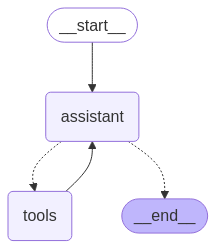

In [7]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(AgentState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [8]:
messages = [HumanMessage(content="Divide 6790 by 5")]

messages = react_graph.invoke({"messages": messages,"input_file":None})

In [9]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Divide 6790 by 5
================================== Ai Message ==================================
Tool Calls:
  divide (call_1QA10jn93vgfMwtdBDAm49Gt)
 Call ID: call_1QA10jn93vgfMwtdBDAm49Gt
  Args:
    a: 6790
    b: 5
================================= Tool Message =================================
Name: divide

1358.0
================================== Ai Message ==================================

6790 divided by 5 is 1358.0.


## Training program
MR Wayne left a note with his training program for the week. I came up with a recipe for dinner leaft in a note.

you can find the document [HERE](https://huggingface.co/datasets/agents-course/course-images/blob/main/en/unit2/LangGraph/Batman_training_and_meals.png), so download it and upload it in the local folder.

![Training](https://huggingface.co/datasets/agents-course/course-images/resolve/main/en/unit2/LangGraph/Batman_training_and_meals.png)

In [10]:
messages = [HumanMessage(content="According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?")]

messages = react_graph.invoke({"messages": messages,"input_file":"Batman_training_and_meals.png"})

In [11]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

According the note provided by MR wayne in the provided images. What's the list of items I should buy for the dinner menu ?
================================== Ai Message ==================================
Tool Calls:
  extract_text (call_4FWJkxKe1vcxlkCzQiRgeBq5)
 Call ID: call_4FWJkxKe1vcxlkCzQiRgeBq5
  Args:
    img_path: Batman_training_and_meals.png
================================= Tool Message =================================
Name: extract_text

TRAINING SCHEDULE  
For the week of 2/20-2/26  

SUNDAY 2/20  
MORNING  
30 minute jog  
30 minute meditation  

EVENING  
clean and jerk lifts—3 reps/8 sets. 262 lbs.  
5 sets metabolic conditioning:  
20 kettle bell swings  
12 pull-ups  
30 minutes flexibility  
30 minutes sparring  

MONDAY 2/21  
MORNING  
30 minute jog  
30 minutes traditional kata (focus on Japanese forms)  

EVENING  
5 sets 20 foot rope climb  
30 minutes gymnastics (work on muscle